In [76]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
from torch import nn, optim

from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms.functional as TF

import PIL
from PIL import Image

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**DATASET**

In [78]:
import re
ROOT_FOLDER_IMAGES='trainsetRNN/image_copy'
ROOT_FOLDER_MASKS='trainsetRNN/truthWithoutSequences'

In [79]:
class CrackDatasetRNN_TF(Dataset):
    def __init__(self, dataPath, masksPath, img_transforms=None, mask_transforms=None):

        self.train_data = dataPath
        self.train_masks = masksPath
        
        self.img_transforms = img_transforms
        self.mask_transforms = mask_transforms
        
        self.img_list = []
        self.mask_list = []
        for folder_typeOfDataAug in set(os.listdir(ROOT_FOLDER_MASKS))-{'desktop.ini'}:
            for folder_videoCaptured in set(os.listdir(os.path.join(ROOT_FOLDER_MASKS,folder_typeOfDataAug)))-{'desktop.ini'}:
                    for img_name in set(os.listdir(os.path.join(ROOT_FOLDER_MASKS,folder_typeOfDataAug, folder_videoCaptured)))-{'desktop.ini'}:
                        self.img_list.append(os.path.join(ROOT_FOLDER_IMAGES,folder_typeOfDataAug,folder_videoCaptured,img_name))
                        self.mask_list.append(os.path.join(ROOT_FOLDER_MASKS,folder_typeOfDataAug,folder_videoCaptured,img_name))
                    
                    
    def __len__(self):
        return len(self.img_list)    
    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        imagen = Image.open(img_path)
        imagen = self.img_transforms(imagen)

        if self.train_masks is not None:
            mask_path = self.mask_list[idx]
            mask = Image.open(mask_path)
            if self.mask_transforms is not None:
                mask = self.mask_transforms(mask)
            else:
                mask = mask
        else:
            return imagen
        
        return imagen, mask    

In [80]:
transform_data = T.Compose([
                T.Resize([224, 224]),
                T.ToTensor(),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transform_data_target = T.Compose([
                T.Resize([224, 224]),
                #T.Grayscale(1),
                T.ToTensor(),
                T.Lambda(lambda x: torch.where(x > 0.5, torch.tensor([1.0]), torch.tensor([0.0])))
                ])

In [81]:
full_dataset = CrackDatasetRNN_TF(ROOT_FOLDER_IMAGES,
                           ROOT_FOLDER_MASKS,
                           img_transforms=transform_data,
                           mask_transforms=transform_data_target)

In [82]:
BATCH_SIZE = 8
TRAIN_SIZE = int(len(full_dataset)*0.8)
VAL_SIZE = len(full_dataset) - TRAIN_SIZE
print(TRAIN_SIZE, VAL_SIZE)
train_dataset, val_dataset = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE])
print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)

387 97
torch.Size([3, 224, 224])
torch.Size([1, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


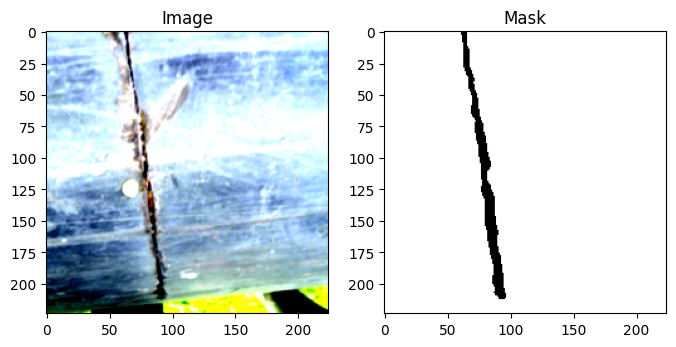

In [83]:
#Check image and mask
id = 100
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(train_dataset[id][0].permute(1, 2, 0));ax[0].set_title("Image")
ax[1].imshow(train_dataset[id][1][0],'binary');ax[1].set_title("Mask")
plt.show()

**Dataloader**

In [84]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [85]:
imgs, masks = next(iter(train_loader))
print(imgs.shape, masks.shape)

torch.Size([8, 3, 224, 224]) torch.Size([8, 1, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


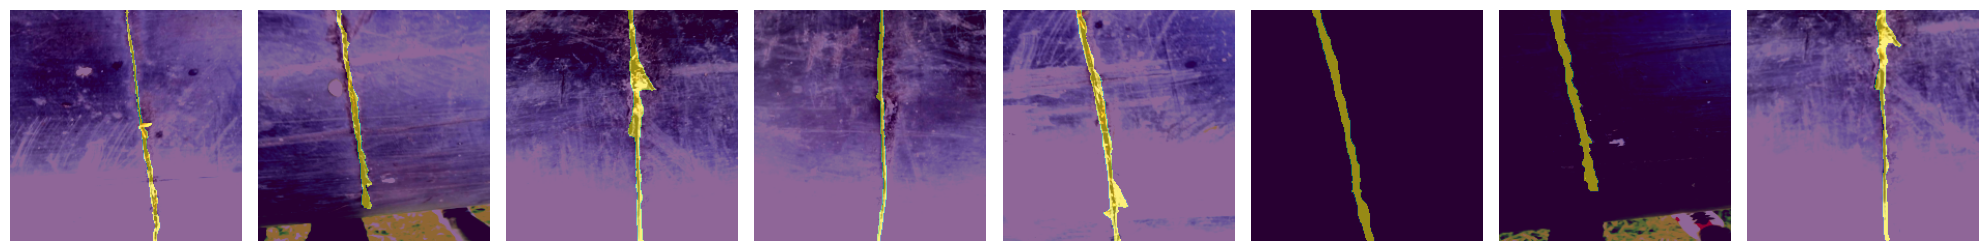

In [86]:
imgs, masks = next(iter(train_loader))
#print(masks)
def plot_mini_batch(imgs, masks):
    plt.figure(figsize=(20,10))
    for i in range(BATCH_SIZE):
        plt.subplot(4, 8, i+1)
        img=imgs[i,...].permute(1,2,0).numpy()
        mask = masks[i, ...][0].numpy()
        #print(masks==1)
        plt.imshow(img)
        plt.imshow(mask, alpha=0.6)
        
        plt.axis('Off')
    plt.tight_layout()
    plt.show()

plot_mini_batch(imgs, masks)

**Model**

**Creating model**

In [87]:
from modelUnet import UNET
model = UNET(3,16, 2)
#model.load_state_dict(torch.load("UNET_Paper_10k_Images_97_Dictv2.pth"))
model.to(device)
print(model)

UNET(
  (first_conv): Double_Conv(
    (double_conv): Sequential(
      (0): Conv_3_k(
        (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv_3_k(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down_conv1): Down_Conv(
    (encoder): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Double_Conv(
        (double_conv): Sequential(
          (0): Conv_3_k(
            (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv_3_k(
            (conv1

**Training**

In [88]:
def accuracy(model, loader):
    correct = 0
    intersection = 0
    denom = 0
    union = 0
    total = 0
    cost = 0.
    model = model.to(device=device)
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype = torch.float32)
            y = y.to(device=device, dtype = torch.long).squeeze(1)
            scores = model(x)
            cost += (F.cross_entropy(scores, y)).item()
            # standard accuracy not optimal
            preds = torch.argmax(scores, dim=1)
            correct += (preds == y).sum()
            total += torch.numel(preds)
            #dice coefficient
            intersection += (preds*y).sum()
            denom += (preds + y).sum()
            dice = 2*intersection/(denom + 1e-8)
            #intersection over union
            union += (preds + y - preds*y).sum()
            iou = (intersection)/(union + 1e-8)
            
        return cost/len(loader), float(correct)/total, dice, iou    

In [89]:
from torch.utils.tensorboard import SummaryWriter

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()
val_losses = []
train_losses = []

train_accs = []
val_accs = []

train_iou = []
val_iou = []

In [90]:
def train(dataloader, model, loss_function, optimizer, epoch, store_every=9):
    train_correct_num, train_total, train_cost_acum = 0, 0, 0.0
    intersection, union = 0, 0
    model.train()
    for batch, (x,y) in enumerate(dataloader):
        x = x.to(device=device, dtype=torch.float32)
        y = y.to(device=device, dtype=torch.long).squeeze(1)
        #print(x.shape)
        scores = model(x)
        cost = loss_function(input=scores, target=y)
        #cost.requires_grad = True


        #Backpropagation
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        train_predictions = torch.argmax(scores, dim=1)
        train_correct_num += (train_predictions == y).sum()
        train_total += torch.numel(train_predictions)#total numero de elementos de train_predictions, if size=[a,b,c ] returns a*b*c
        train_cost_acum += cost
        
        #IOU
        intersection += (train_predictions*y).sum()
        union += (train_predictions + y - train_predictions*y).sum()
 
        if batch % store_every == 1:#1 cuz division by zero
            train_acc = float(train_correct_num)/train_total#el train total ya considera el batch
            train_cost_every = float(train_cost_acum)/batch#Se divide entre el batch, xq por cada batch se aumenta el loss
            iou_every = ((intersection)/(union + 1e-8)).item()
            writer.add_scalar('training loss',
                            train_cost_every,
                            epoch * len(dataloader) + batch)#len(dataloader) returns total number of batchs in an epoch
            writer.add_scalar('training accuracy',
                            train_acc,
                            epoch * len(dataloader) + batch)
            writer.add_scalar('training IOU',
                            iou_every,
                            epoch * len(dataloader) + batch)
            
            print("loss: ", train_cost_every, "Accuracy: ", train_acc, "IOU: ", iou_every)
            train_losses.append(train_cost_every)
            train_accs.append(train_acc)
            train_iou.append(iou_every)

In [91]:
def val(dataloader, model, loss_function,epoch):
    num_batches = len(dataloader)
    model.eval()
    val_loss, val_correct_num, val_total = 0.0, 0, 0
    intersection, union = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device=device, dtype=torch.float32)
            y = y.to(device=device, dtype=torch.long).squeeze(1)
            pred = model(x)
            loss = loss_function(input=pred, target=y)
            
            val_loss += loss.item()
            val_predictions = torch.argmax(pred, dim=1)
            val_correct_num += ((val_predictions == y).sum()).item()
            val_total += torch.numel(val_predictions)

            #IOU
            intersection += (val_predictions*y).sum()
            union += (val_predictions + y - val_predictions*y).sum()

    val_loss /= num_batches
    val_correct_num = val_correct_num/val_total
    IOU = ((intersection)/(union + 1e-8)).item()
    writer.add_scalar('validation loss',
                    val_loss,epoch)
    writer.add_scalar('validation accuracy',
                    val_correct_num,epoch)
    writer.add_scalar('validation IOU',
                    IOU,epoch)
    print(f"Validation Error: \n Accuracy: {(100*val_correct_num):>0.1f}%, Avg loss: {val_loss:>8f}, IOU: {IOU:>0.3f} \n")
    val_losses.append(val_loss)
    val_accs.append(val_correct_num)
    val_iou.append(IOU)

In [98]:
loss_fn = torch.nn.CrossEntropyLoss()#Hace el softmax y la funcion costo al mismo tiempo
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
epochs = 1
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer, epoch)
    val(val_loader, model, loss_fn, epoch)
writer.close()

Epoch 1
-------------------------------
loss:  0.0602966770529747 Accuracy:  0.9872324418048469 IOU:  0.6351664066314697
loss:  0.031234690546989442 Accuracy:  0.9882601877753943 IOU:  0.6557831168174744
loss:  0.02877620019410786 Accuracy:  0.9883853834502551 IOU:  0.6628057360649109
loss:  0.028322060193334306 Accuracy:  0.9886434234254047 IOU:  0.6688078045845032
loss:  0.027598722560985667 Accuracy:  0.9888965184655276 IOU:  0.6718348860740662
loss:  0.026777526606684147 Accuracy:  0.9891593823782837 IOU:  0.6801410913467407
Validation Error: 
 Accuracy: 99.0%, Avg loss: 0.024556, IOU: 0.651 



In [99]:
import pandas as pd
def precision_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 3)

def recall_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 3)

def accuracy(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    xor = np.sum(groundtruth_mask==pred_mask)
    acc = np.mean(xor/(union + xor - intersect))
    return round(acc, 3)

def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

def metrics_table(gt_masks, pred_masks):
    metrics = {'Precision':[],'Recall':[],'Accuracy':[],'Dice':[],'IoU':[]}
    for i, (mask, pred) in enumerate(zip(gt_masks, pred_masks)):
        metrics['Precision'].append(precision_score_(mask, pred))
        metrics['Recall'].append(recall_score_(mask, pred))
        metrics['Accuracy'].append(accuracy(mask, pred))
        metrics['Dice'].append(dice_coef(mask, pred))
        metrics['IoU'].append(iou(mask, pred))
    df = pd.DataFrame.from_dict(metrics)
    df.columns = ['Precision', 'Recall', 'Accuracy', 'Dice', 'IoU']
    return df

In [100]:
all_x = []
all_y = []

# Itera sobre el DataLoader para obtener los datos
for batch_x, batch_y in val_loader:
    all_x.append(batch_x)
    all_y.append(batch_y)

print(len(all_x), len(all_y))

13 13


In [101]:
modelo = model.to(device)
df_list = []

for imgs,masks in zip(all_x, all_y):
    imgs_val = imgs.to(device, dtype=torch.float32)
    with torch.no_grad():
        scores = model(imgs_val)
        #print(scores.shape)
        preds = torch.argmax(scores, dim=1).float()
        #print(preds==1)
    imgs_val = imgs_val.cpu()
    preds = preds.cpu()
    preds = preds.numpy()
    masks = masks.numpy()
    df_iteration = metrics_table(masks.squeeze(), preds)
    df_list.append(df_iteration)

# Concatenate all the DataFrames together into one large DataFrame
df_combined = pd.concat(df_list, ignore_index=True)

# Calculate the median row and store it in a new DataFrame
median_row = df_combined.median(axis=0).to_frame().transpose()

print("Median Row:")
print(median_row)

Median Row:
   Precision  Recall  Accuracy   Dice    IoU
0      0.924   0.728     0.991  0.797  0.663


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


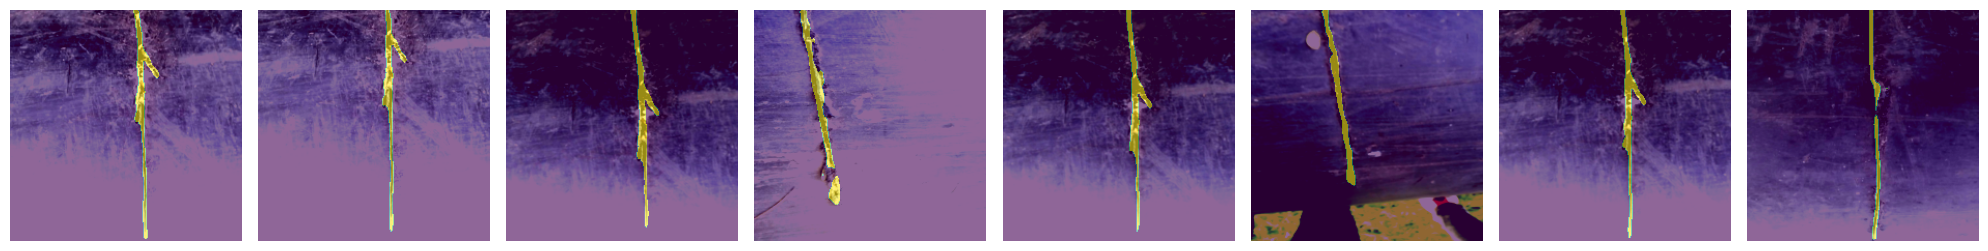

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


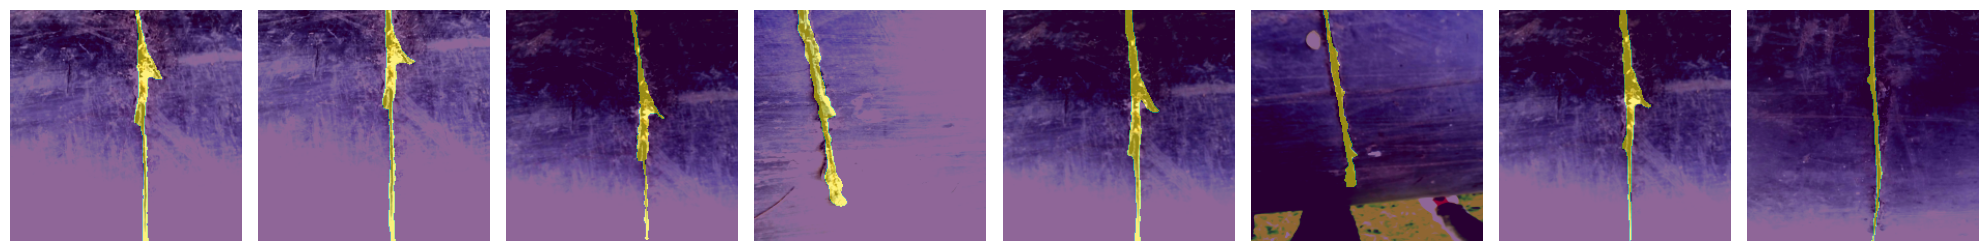

,Precision,Recall,Accuracy,Dice,IoU
0,0.917,0.710,0.989,0.800,0.667
1,0.973,0.650,0.987,0.779,0.638
2,0.893,0.804,0.992,0.846,0.733
3,0.923,0.588,0.981,0.719,0.561
4,1.000,0.620,0.985,0.766,0.620
5,0.927,0.805,0.994,0.862,0.757
6,0.908,0.685,0.988,0.780,0.640
7,0.852,0.729,0.992,0.785,0.647


In [102]:
imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    #print(scores.shape)
    preds = torch.argmax(scores, dim=1).float()
    #print(preds==1)
imgs_val = imgs_val.cpu()
preds = preds.cpu()
masks_val = masks_val.cpu()

plot_mini_batch(imgs_val, preds.unsqueeze(1))
plot_mini_batch(imgs_val, masks_val)

masks_val = masks_val.numpy()
preds = preds.numpy()
metrics_table(masks_val.squeeze(), preds)

In [ ]:
from matplotlib import pyplot as plt
plt.plot([los for los in train_losses], label='train_loss')
plt.plot(val_losses,label='val_loss')
plt.legend()
plt.show

In [ ]:
plt.plot(train_accs, label='train_acc')
plt.plot([ac.data.cpu() for ac in val_accs], label='val_acc')
plt.legend()
plt.show

In [103]:
torch.save(model.state_dict(), "UNET_Paper_OwnDataset_TF_Dictv3.pth")
torch.save(model, "UNET_Paper_OwnDataset_TF_DictCompletev3.pth")

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
imgs_val, masks_val = next(iter(test_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model = model.to(device)
with torch.no_grad():
    scores = model(imgs_val)
    print(scores.shape)
    preds = torch.argmax(scores, dim=1).float()
    print(preds==1)
imgs_val = imgs_val.cpu()
preds = preds.cpu()
#print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))

In [ ]:
import segmentation_models_pytorch as smp
import torch
# Cargar el modelo entrenado
from modelUnet import UNET
model_read = UNET(3,16, 2)
model_read.load_state_dict(torch.load('UNET_Paper_10k_Images_97_Dict.pth'))

# Establecer el modelo en modo de evaluación
model_read.eval()


imgs_val, masks_val = next(iter(val_loader))
imgs_val = imgs_val.to(device, dtype=torch.float32)
model_read = model_read.to(device)
with torch.no_grad():
    scores = model_read(imgs_val)
    #print(scores.shape)
    preds = torch.argmax(scores, dim=1).float()
    #print(preds==1)
imgs_val = imgs_val.cpu()
preds = preds.cpu()
#print(preds.shape)
plot_mini_batch(imgs_val, preds.unsqueeze(1))